# Setup

## Installs

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

import gpxpy
import folium

from route import Route, RouteGroup

In [2]:
plt.ioff()  # Turn off interactive mode

# Read the GPX file and instantiate the Route object

In [3]:
GPX_FILE_PATH = '../gpx/'

# Read the GPX file
gpx_file_name = 'lamision-brasil-80-2025.gpx'
full_gpx_file_path = os.path.join(GPX_FILE_PATH, gpx_file_name)
route = Route(full_gpx_file_path)


# Usage

In [4]:
# Test that basic attributes are loaded
print("Basic attributes test:")
print(f"Total distance: {route.total_distance/1000:.1f} km")
print(f"Total elevation gain: {round(route.elevation_gain):,} m")
print(f"Total elevation loss: {round(route.elevation_loss):,} m")
print(f"Average elevation gain per km: {round(route.avg_elevation_gain_per_km):,} m")
print(f"Route % of hard slopes (above {100*route.HARD_SLOPE_THRESHOLD:.0f}%): {100*route.hard_slope_percentage:.1f}%")

Basic attributes test:
Total distance: 87.5 km
Total elevation gain: 6,069 m
Total elevation loss: 6,071 m
Average elevation gain per km: 69 m
Route % of hard slopes (above 20%): 24.0%


In [5]:
# Plot the map
route_map = route.plot_map()
route_map

In [6]:
# Plot the elevation profile
elevation_profile = route.plot_elevation_profile()
elevation_profile


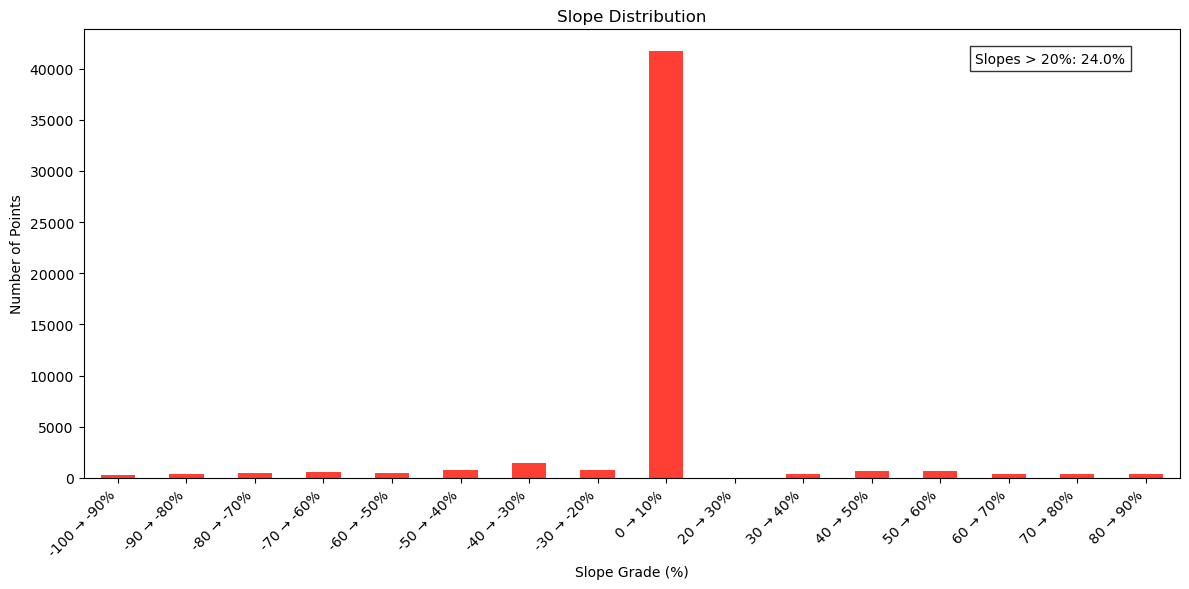

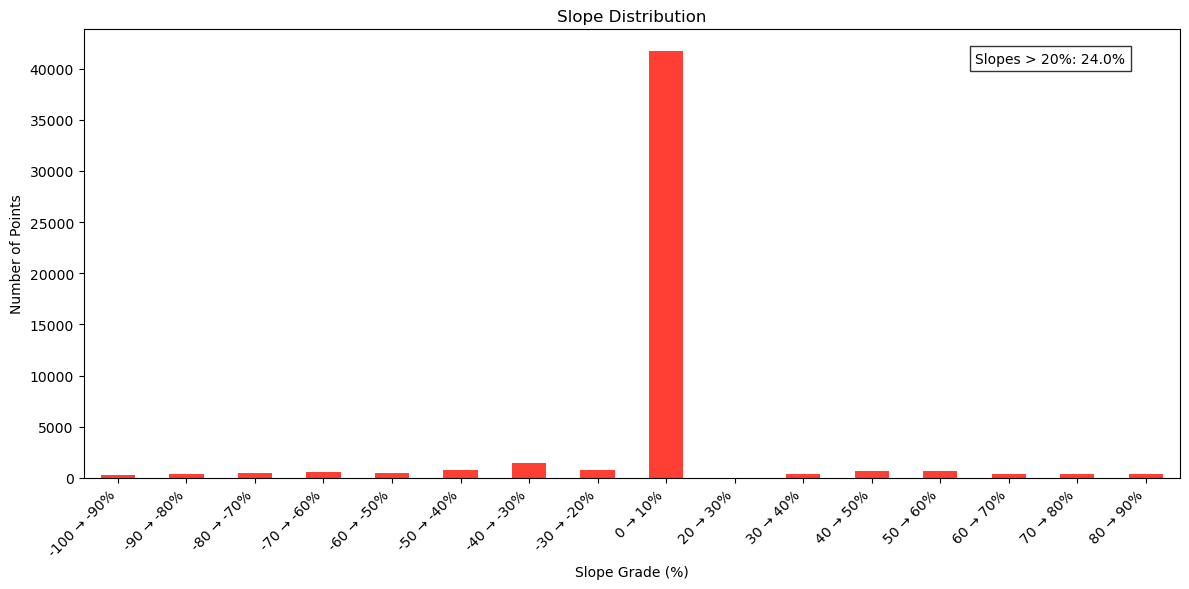

In [7]:
# Plot the slope histogram
slope_histogram = route.plot_slope_histogram()
slope_histogram

In [8]:
# Display the route's DataFrame
route.df

,latitude,longitude,elevation,elevation_diff,distance_between_points_3d,distance_between_points_2d,cum_distance_3d_km,cum_distance_2d_km,cum_elevation,slope_gradient,slope_bin,hard_slope
0,-22.390313,-44.966153,922.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0 → 10%,False
1,-22.390324,-44.966142,922.0,0.0,1.679232,1.679232,0.001679,0.001679,0.0,0.000000,0 → 10%,False
2,-22.390335,-44.966130,922.0,0.0,1.703083,1.703083,0.003382,0.003382,0.0,0.000000,0 → 10%,False
3,-22.390351,-44.966129,922.0,0.0,1.786931,1.786931,0.005169,0.005169,0.0,0.000000,0 → 10%,False
4,-22.390367,-44.966127,922.0,0.0,1.786131,1.786131,0.006955,0.006955,0.0,0.000000,0 → 10%,False
...,...,...,...,...,...,...,...,...,...,...,...,...
49942,-22.390664,-44.966779,919.0,0.0,1.743539,1.743539,87.450264,83.374313,-3.0,0.000000,0 → 10%,False
49943,-22.390663,-44.966794,919.0,0.0,1.517972,1.517972,87.451782,83.375831,-3.0,0.000000,0 → 10%,False
49944,-22.390662,-44.966808,920.0,1.0,1.817757,1.517973,87.453599,83.377349,-2.0,0.658773,60 → 70%,True
49945,-22.390667,-44.966827,920.0,0.0,1.977120,1.977120,87.455576,83.379326,-2.0,0.000000,0 → 10%,False


# Compare routes

In [9]:
# Create a route group
group = RouteGroup()

# Add routes with custom labels
group.add_route(
    route=Route(os.path.join(GPX_FILE_PATH, 'wtr-campos-19-2024.gpx')),
    label='wtr-campos-19-2024'
)
group.add_route(
    route=Route(os.path.join(GPX_FILE_PATH, 'indomit-saobentosdosapucai-21-2024.gpx')),
    label='indomit-saobentosdosapucai-21-2024'
)

# Compare stats
compare_stats_df = group.compare_stats()
display(compare_stats_df)

# Plot elevation comparison
elevation_comparison = group.plot_elevation_comparison()
elevation_comparison

,Route,Distance (km),Elevation Gain (m),Elevation Loss (m),Avg Gain per km (m),Hard Slopes (%)
0,wtr-campos-19-2024,18.8,801,801,43,23.0
1,indomit-saobentosdosapucai-21-2024,21.6,1198,1098,55,25.1
